<a href="https://colab.research.google.com/github/lizzzb/MovieLens-Data-Analysis-in-Python/blob/main/SAR_CollFil_MovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Collaborative Filtering Methods:
* Memory Methods
  
  * SAR -> two matrices
* Matrix Factorization
* Factorization Machines
  * MF + user/item features
  * the way to solve negative feedback problem
* Pairwise Ranking
  * In pairwise ranking, we create a different data set that has preferences over pairs of interactions. By collecting pairwise comparisons, the model can learn user preferences and generate personalized recommendations, avoiding the negative feedback problem.
* Multilayer Perceptrones
* Graph Neural Networks
   * A graph network is a type of network that is designed to operate on graph structured data. The data and recommendation systems can be represented as graphs where the users and items are the nodes in the graph and the interactions are the connections between nodes.
* Transformers

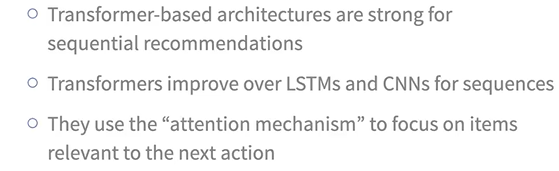

### Content-based Filtering Methods:
* Tree-based algorithms
   * Gradient Boosting decision trees
   * Random Forest
* Nearest-neighbor methods
   * We can use K-NN methods in classification or regression where the K is the number of similar feature vectors we want to use for computation.
   * In a classification scenario, like buy or not buy, the K-NN algorithm computes an unknown class as the most common class of the K nearest neighbors.
   * In contrast, in regression, K-NN calculates the average of the K nearest neighbors.
   * To find the neighbors in the feature-space, we use similarity metrics like cosine similarity or others.
* Transformers
   * Work particularly well when there is text data. Think about using the description of the items.
* Logistic Regression
   * GB will beat it
   * Either use as re-ranker or when the amount of the data is extremely massive.

# SAR: A Memory-Based Method

!It is algebraic algorithm!


Prediction of SAR is not a rating, it is  just a score. It measures the strength of the interest between a specific user and a specific item.

We compute the items that are similar to each other, and then, we recommend the items that are similar to those the user has an affinity for.

SAR algorithm is implemented using two matrices. **The item similarity matrix estimates item-item relationships.** **The affinity matrix estimates user-item relationships.** The recommendation scores are then created by **multiplying the similarity matrix and the affinity matrix.** The result we get is just a predicted R matrix where each user will have a score for each movie. Then the only thing we need to do is get the items with the highest score for each user.

The SAR similarity matrix can be computed using different similarity matrix.

But here, we are just going to discuss three: co-occurrence, Jaccard, and lift.

1. Co-occurrence is defined as **the number of times two items appear together for a given user**. We represent the co-occurrence as a square matrix where **each component of the matrix is the number of times item i occurred with item j.** To obtain Jaccard and lift, we rescale the co-occurrence matrix according to specific formulas. In general, using co-occurrence as a similarity matrix favor predictability. Meaning that the most popular items will be recommended most of the time.
2. Lift, by contrast, favors **discoverability and serendipity**. An item that is less popular overall but highly favored by a small subset of users is more likely to be recommended.
3. Jaccard is a compromise between the two.

Now let's turn to the affinity matrix.

 **The SAR affinity matrix captures the strength of the relationship between the user and an item that the user has interacted with.** SAR incorporates two factors that can impact users' affinities. It can consider information about the type of user-item interaction by weighting different events.

 For example, in the movie example before, **we can weight the interaction view as one, click as three, and watch full movie as 10.**

 It can also consider information about when a user-item event occurred and **discount events that took place in the past.** For example, we want to reduce the weight of all interactions that happened, let's say, three months ago.

 After multiplying the similarity and affinity matrix, we get **a score for each user and item pair. To recommend items to a user, we just order the scores.** That gives us a ranking of the items that are going to be recommended.
  
  SAR is the first recommender I would try. It is fast. You notice that it's just matrix multiplication. It is scalable. It can easily be implemented in these computers, like Spark or GPUs. And it is easy to interpret.

  ### Advantages of SAR:
- High accuracy for an easy to train and deploy algorithm
- Fast training, only requiring simple counting to construct matrices used at prediction time.
- Fast scoring, only involving multiplication of the similarity matrix with an affinity vector

### Notes to use SAR properly:
- Since it does not use item or user features, it can be at a disadvantage against algorithms that do.
- It's memory-hungry, requiring the creation of an $mxm$ sparse square matrix (where $m$ is the number of items). This can also be a problem for many matrix factorization algorithms.
- SAR favors an implicit rating scenario and it does not predict ratings.

This notebook provides an example of how to utilize and evaluate SAR in Python on a CPU.

SAR (Simple Association Rules) is a memory-based collaborative filtering method that can address cold start problems in recommendation systems. Here's why:

    * No need for historical data: SAR relies on association rules mined from current user-item interactions instead of user/item historical data, which is beneficial in cold start scenarios where new users or items have limited interaction history.
    * Finding similar users or items: SAR can identify similar users or items based on their interactions. For instance, if two users interact with the same items, they might have similar preferences. This allows the algorithm to recommend items to new users based on the preferences of similar users, even if the new users have no prior interactions.


In [1]:
!pip install recommenders

  Using cached pandera-0.20.4-py3-none-any.whl.metadata (15 kB)
Using cached pandera-0.20.4-py3-none-any.whl (259 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.7.1
    Uninstalling pandera-0.7.1:
      Successfully uninstalled pandera-0.7.1


In [3]:
!pip install pandera

In [5]:
pip install --upgrade pandera recommenders

In [2]:
pip install pandera==0.7.1

  Using cached pandera-0.7.1-py3-none-any.whl.metadata (10 kB)
Using cached pandera-0.7.1-py3-none-any.whl (165 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.20.4
    Uninstalling pandera-0.20.4:
      Successfully uninstalled pandera-0.20.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
recommenders 1.2.0 requires pandera[strategies]>=0.15.0; python_version >= "3.9", but you have pandera 0.7.1 which is incompatible.


In [3]:
# Global Settings and Imports
import logging
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.models.sar import SAR
from recommenders.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    rmse,
    mae,
    logloss,
    rsquared,
    exp_var
)

### 1. Load Data

SAR is intended to be used on interactions with the following schema:
`<User ID>, <Item ID>,<Time>,[<Event Type>], [<Event Weight>]`.

**Each row represents a single interaction between a user and an item**. These interactions might be different types of events on an e-commerce website, such as a user clicking to view an item, adding it to a shopping basket, following a recommendation link, and so on. Each event type can be assigned a different weight, for example, we might assign a “buy” event a weight of 10, while a “view” event might only have a weight of 1.

The MovieLens dataset is well formatted interactions of Users providing Ratings to Movies (movie ratings are used as the event weight) - we will use it for the rest of the example.

### 1.1 Download and use the MovieLens Dataset

In [4]:
# Top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "100k"

# Other data settings
USER_COL = "userID"
ITEM_COL = "itemID"
RATING_COL = "rating"
TIMESTAMP_COL = "timestamp"
PREDICTION_COL = "prediction"

# Train test split ratio
SPLIT_RATIO = 0.75

# Model settings
SIMILARITY_TYPE = "jaccard"
TIME_DECAY = 30 # number of days until the weight of the ratings are decayed by 1/2

SEED = 42 # seed for random number generators
logging.basicConfig(level=logging.DEBUG, format="%(levelname)-8s %(message)s")

`SIMILARITY_TYPE = "jaccard"`: Specifies "Jaccard similarity" as the method for measuring similarity between users or items (common in collaborative filtering).

`TIME_DECAY = 30`: A numerical value likely used in time-aware recommendation algorithms to give more weight to recent interactions. The exact meaning depends on the specific

logging.basicConfig(level=logging.DEBUG, format="%(levelname)-8s %(message)s")

Use code with caution

This line tells your program how to display messages when it encounters things it needs to tell you (errors, warnings, information, etc.).

    logging.basicConfig(...): Think of this as setting up a message board for your program.

    level=logging.DEBUG: This means your message board will show all types of messages, even the very detailed ones (like debugging messages).
    
    format="%(levelname)-8s %(message)s": This is like choosing the design of the messages on your board. It says:
    Show the type of message (e.g., "DEBUG", "WARNING") in a small box.
    After the box, show the actual message itself.

So, if your program encounters a problem, it might display something like this on your "message board":

    ERROR     Something went wrong!

The ERROR is in a little box, and then the message "Something went wrong!" is displayed next to it. This helps you quickly understand what kind of message it is.


In [5]:
### 1.1 Download and use the MovieLens Dataset

data = movielens.load_pandas_df(size=MOVIELENS_DATA_SIZE)

# Convert the float precision to 32-bit in order to reduce memory consumption
data[RATING_COL] = data[RATING_COL].astype(np.float32)

data.head()

100%|██████████| 4.81k/4.81k [00:01<00:00, 4.36kKB/s]


,userID,itemID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


### 1.2 Split the data using the python random splitter provided in utilities:

We split the full dataset into a `train` and `test` dataset **to evaluate performance of the algorithm against a held-out set not seen during training.**

**Because SAR generates recommendations based on user preferences, all users that are in the test set must also exist in the training set.** For this case, we can use the provided `python_stratified_split` function which holds out a percentage (in this case 25%) of items from each user, but **ensures all users are in both `train` and `test` datasets.**

Other options are available in the `dataset.python_splitters` module which provide more control over how the split occurs.

In [6]:
train, test = python_stratified_split(data, ratio=SPLIT_RATIO, filter_by="user", col_user=USER_COL, col_item=ITEM_COL, seed=SEED)

In [7]:
print("""
Train:
Total Ratings: {train_total}
Unique Users: {train_users}
Unique Items: {train_items}

Test:
Total Ratings: {test_total}
Unique Users: {test_users}
Unique Items: {test_items}
""".format(
    train_total=len(train),
    train_users=len(train[USER_COL].unique()),
    train_items=len(train[ITEM_COL].unique()),
    test_total=len(test),
    test_users=len(test[USER_COL].unique()),
    test_items=len(test[ITEM_COL].unique()),
))


Train:
Total Ratings: 74992
Unique Users: 943
Unique Items: 1653

Test:
Total Ratings: 25008
Unique Users: 943
Unique Items: 1444



## 2. Train the SAR Model

### 2.1 Instantiate the SAR algorithm and set the index

We will use **the single node implementation of SAR** and specify the column names to match our dataset (timestamp is an optional column that is used and can be removed if your dataset does not contain it).
  
  The single node implementation of SAR involves two matrices:

  * User-item rating matrix: This matrix stores the ratings given by users to items.
  * Similarity matrix: This matrix stores the similarity between users or items.



In [9]:
model = SAR(
    col_user=USER_COL,
    col_item=ITEM_COL,
    col_rating=RATING_COL,
    col_timestamp=TIMESTAMP_COL,
    similarity_type=SIMILARITY_TYPE,
    time_decay_coefficient=30,
    timedecay_formula=True,
    normalize=True
)

This code snippet initializes a SAR model with specified parameters. Let's break down what each parameter means:

* `time_decay_coefficient=30`: A numerical value used in the time decay formula to control how much weight is given to older interactions.
* `timedecay_formula=True`: Indicates whether to apply a time decay factor to the similarity scores.
* `normalize=True`: Indicates whether to normalize the user-item rating matrix.

### 2.2 Train the SAR model on our training data, and get the top-k recommendations for our testing data

SAR first computes an item-to-item ***co-occurence matrix***. Co-occurence represents the number of times two items appear together for any given user. Once we have the co-occurence matrix, we compute an ***item similarity matrix*** by rescaling the cooccurences by a given metric (Jaccard similarity in this example).

We also compute an ***affinity matrix*** to capture the strength of the relationship between each user and each item. Affinity is driven by different types (like *rating* or *viewing* a movie), and by the time of the event.

Recommendations are achieved by multiplying the affinity matrix $A$ and the similarity matrix $S$. The result is a ***recommendation score matrix*** $R$. We compute the ***top-k*** results for each user in the `recommend_k_items` function seen below.


In [10]:
with Timer() as train_time:
    model.fit(train)

print(f"Took {train_time.interval} seconds for training.")

Took 1.2471699070001705 seconds for training.




```
INFO     Collecting user affinity matrix
INFO     Calculating time-decayed affinities
INFO     Creating index columns
INFO     Calculating normalization factors
INFO     Building user affinity sparse matrix
INFO     Calculating item co-occurrence
INFO     Calculating item similarity
INFO     Using jaccard based similarity
INFO     Done training
Took 0.5214087999775074 seconds for training.
```
These log messages indicate the steps involved in training your SAR model. Here's a breakdown of what each message means:

* Collecting user affinity matrix: **Gathers information about user interactions** (ratings, purchases, etc.) to build a matrix representing user preferences.
* Calculating time-decayed affinities: Applies a time decay function (if enabled) **to give more weight to recent user interactions and less weight to older ones.**
* Creating index columns: **Creates indexes for users and items to efficiently access and manipulate the data within the matrices.**
* Calculating normalization factors: **Computes values used to normalize the data in the user-item matrix**, which can improve the performance of similarity calculations.
* Building user affinity sparse matrix:** Constructs a sparse matrix representation of the user affinity data**, which can be more memory-efficient for large datasets.
* Calculating item co-occurrence: **Determines how frequently items appear together in user interactions** (e.g., how often two products are purchased together).
* Calculating item similarity: **Computes similarity scores between items based on their co-occurrence patterns.**
* Using jaccard based similarity: Indicates that the Jaccard similarity metric was used to measure item similarity.
* Done training: Signals that the training process is complete and the model is ready to make recommendations.



In [12]:
with Timer() as test_time:
    top_k = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 0.28559886299990467 seconds for prediction.


`top_k = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)`: This line uses your trained SAR model (model) to recommend items for users in your test dataset (test). It generates recommendations for the top TOP_K items and excludes items the user has already interacted with (remove_seen=True).

`recommend_k_items` is a method of the SAR model class. It generates the top k recommendations for each user in the input dataset.

The method takes several parameters, including:

* The dataset on which to make predictions.
* top_k, which determines the number of recommendations to generate for each user.
* remove_seen, which is a boolean value specifying whether to exclude items the user has already interacted with from the recommendations.

The method returns a dataframe containing the recommendations for each user.

In [13]:
top_k.head()

,userID,itemID,prediction
0,1,433,2.910697
1,1,204,2.906224
2,1,403,2.906136
3,1,174,2.870639
4,1,70,2.863253


n this context, "prediction" refers to the process of the SAR model generating recommendations for users in the test dataset.

Although recommendation systems don't predict future events in the traditional sense, they predict user preferences based on patterns in the data. The model uses its learned knowledge to suggest items the user might like, even if they haven't interacted with those items before.

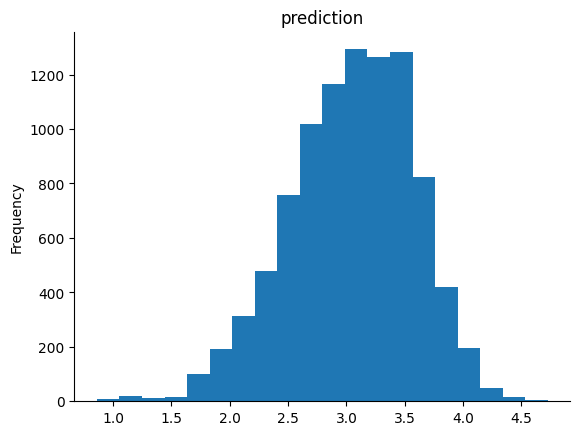

In [14]:
# @title prediction

from matplotlib import pyplot as plt
top_k['prediction'].plot(kind='hist', bins=20, title='prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

Central Tendency: The model predicts most ratings around the average score of 3.0 to 3.5, suggesting moderate user-item affinities.

### 2.3. Evaluate how well SAR performs

We evaluate how well SAR performs for a few common ranking metrics provided in the `python_evaluation` module.

We will consider the Mean Average Precision (MAP), Normalized Discounted Cumalative Gain (NDCG), Precision, and Recall for the top-k items per user we computed with SAR. User, item and rating column names are specified in each evaluation method.

In [15]:
# Ranking metrics
eval_map = map_at_k(test, top_k, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL, k=TOP_K)
eval_ndcg = ndcg_at_k(test, top_k, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL, k=TOP_K)
eval_precision = precision_at_k(test, top_k, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL, k=TOP_K)
eval_recall = recall_at_k(test, top_k, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL, k=TOP_K)


/usr/local/lib/python3.10/dist-packages/recommenders/evaluation/python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
/usr/local/lib/python3.10/dist-packages/recommenders/evaluation/python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


In [16]:
# Rating metrics
eval_rmse = rmse(test, top_k, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL)
eval_mae = mae(test, top_k, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL)
eval_rsquared = rsquared(test, top_k, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL)
eval_exp_var = exp_var(test, top_k, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL)


In [17]:
positivity_threshold = 2
test_bin = test.copy()
test_bin[RATING_COL] = binarize(test_bin[RATING_COL], positivity_threshold)

top_k_prob = top_k.copy()
top_k_prob[PREDICTION_COL] = minmax_scale(top_k_prob[PREDICTION_COL].astype(float))

eval_logloss = logloss(
    test_bin, top_k_prob, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL
)


Here the goal is to compute **log loss** (or logarithmic loss) for a recommendation system, which measures the accuracy of probabilistic predictions.

Here’s a breakdown of what each line does:

### 1. Setting a Positivity Threshold for Binarization
```python
positivity_threshold = 2
test_bin = test.copy()
test_bin[RATING_COL] = binarize(test_bin[RATING_COL], positivity_threshold)
```
- **`positivity_threshold = 2`**: This sets a threshold where ratings are converted into binary labels. In this case, a rating greater than or equal to `2` will be considered positive (1), and anything below `2` will be negative (0).
  
- **`binarize(test_bin[RATING_COL], positivity_threshold)`**: This converts the ratings in the test set (`test_bin`) into binary values (0 or 1) based on the threshold you defined. Ratings greater than or equal to `2` will be set to `1` (positive interaction), and ratings below `2` will be set to `0` (negative interaction).

### 2. Scaling Predictions with Min-Max Normalization
```python
top_k_prob = top_k.copy()
top_k_prob[PREDICTION_COL] = minmax_scale(top_k_prob[PREDICTION_COL].astype(float))
```
- **`top_k.copy()`**: This creates a copy of the `top_k` DataFrame that contains the top `K` recommendations for each user.

- **`minmax_scale(top_k_prob[PREDICTION_COL].astype(float))`**:
   - This applies **min-max scaling** to the prediction scores, transforming them into a range between 0 and 1. This is essential for probabilistic evaluation metrics like log loss, which expect predicted probabilities.
   - Min-max scaling works by transforming values to fit within the `[0, 1]` range, using the formula:
   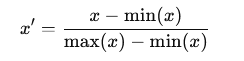
   - `astype(float)` ensures that the prediction values are treated as floats during scaling.

### 3. Computing Log Loss
```python
eval_logloss = logloss(
    test_bin, top_k_prob, col_user=USER_COL, col_item=ITEM_COL, col_rating=RATING_COL
)
```
- **`logloss`**: This is the function used to calculate the **logarithmic loss**. It compares the binary labels (from `test_bin`) with the predicted probabilities (from `top_k_prob`) and computes a score that reflects how well the model's predicted probabilities match the actual labels.
  
- **Inputs to `logloss`**:
   - `test_bin`: This is the binarized test dataset (where the ratings have been converted to 0 or 1).
   - `top_k_prob`: This contains the predicted probabilities (after min-max scaling) for the top `K` items.
   - `col_user`, `col_item`, `col_rating`: These are the columns that identify users, items, and ratings, respectively.

### **What Is Log Loss?**
Log loss, also known as binary cross-entropy, is a metric that quantifies the uncertainty of the predictions in probabilistic models. It penalizes incorrect classifications with higher confidence more than incorrect classifications with lower confidence.

The formula for log loss is:

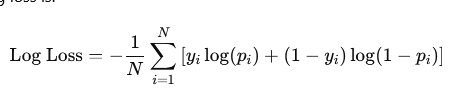

Where:
- \(y_i\) is the actual binary label (0 or 1).
- \(p_i\) is the predicted probability.
- \(N\) is the total number of samples.

### **Summary of the Code's Purpose**:
1. The test dataset is binarized to represent positive and negative interactions based on a rating threshold.
2. The predicted scores are scaled to a `[0, 1]` range to represent probabilities.
3. Log loss is computed, which measures the accuracy of the probabilistic predictions. Lower log loss values indicate better predictions (closer to the true values).


In [18]:
print("Model:\t\tSAR",
      "Top K:\t\t%d" % TOP_K,
      "MAP:\t\t%f" % eval_map,
      "NDCG:\t\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall,
      "RMSE:\t\t%f" % eval_rmse,
      "MAE:\t\t%f" % eval_mae,
      "R2:\t\t%f" % eval_rsquared,
      "Exp var:\t%f" % eval_exp_var,
      "Logloss:\t%f" % eval_logloss,
      sep='\n')

Model:		SAR
Top K:		10
MAP:		0.244722
NDCG:		0.379533
Precision@K:	0.331071
Recall@K:	0.176837
RMSE:		1.229246
MAE:		1.033912
R2:		-0.511334
Exp var:	0.098494
Logloss:	0.569153


This table summarizes the evaluation metrics for a **SAR (Simple Algorithm for Recommendations)** model, with a focus on its performance at **Top K = 10** recommendations. Below is a detailed explanation of each metric:

### **1. MAP (Mean Average Precision)**: `0.244722`
- **Definition**: Measures the precision of the ranked items in the recommendation list, focusing on the top `K`. It evaluates both the relevance and the order of items.
- **Interpretation**: A MAP of `0.2447` indicates that, on average, **approximately 24.47% of the items in the top 10 recommendations are relevant and ranked in the correct order.**

### **2. NDCG (Normalized Discounted Cumulative Gain)**: `0.379533`
- **Definition**: Evaluates the quality of the ranking by considering both the relevance and the position of recommended items. Higher relevance at higher ranks is rewarded more.
- **Interpretation**: An NDCG score of `0.3795` suggests a moderate performance, where some relevant items are correctly ranked at the top but with room for improvement.

### **3. Precision@K**: `0.331071`
- **Definition**: Precision measures the percentage of relevant items among the top `K` recommendations.
- **Interpretation**: A precision of `0.3311` means that, on average, 33.11% of the top 10 recommendations are relevant.

### **4. Recall@K**: `0.176837`
- **Definition**: Recall measures how many of the relevant items are retrieved among the top `K` recommendations.
- **Interpretation**: A recall of `0.1768` means that 17.68% of the relevant items for each user are being captured in the top 10 recommendations.

### **5. RMSE (Root Mean Squared Error)**: `1.229246`
- **Definition**: Measures the difference between the predicted and the actual ratings, focusing on the magnitude of the error.
- **Interpretation**: An RMSE of `1.2292` suggests the predicted ratings deviate from the actual ratings by approximately 1.23 on average.

### **6. MAE (Mean Absolute Error)**: `1.033912`
- **Definition**: The average of the absolute differences between the predicted and actual ratings.
- **Interpretation**: An MAE of `1.0339` indicates that, on average, the predicted rating is off by about 1 point from the true rating.

### **7. R² (R-Squared)**: `-0.511334`
- **Definition**: Measures how well the model explains the variance in the actual ratings. A value closer to `1` means the model explains the variance well, while negative values indicate poor fit.
- **Interpretation**: An R² of `-0.5113` indicates that the model is performing worse than a simple mean-based predictor (i.e., the model does not explain the variance in the data).

### **8. Exp var (Explained Variance)**: `0.098494`
- **Definition**: Measures the proportion of variance explained by the model. It ranges from `0` to `1`, with higher values indicating better performance.
- **Interpretation**: An explained variance of `0.0985` suggests that the model explains only about 9.85% of the variance in the actual ratings, indicating a weak predictive performance.

### **9. Logloss**: `0.569153`
- **Definition**: Measures the uncertainty of the predictions by comparing the predicted probabilities of relevance with the actual binary labels (relevant vs. non-relevant). Lower values indicate better performance.
- **Interpretation**: A log loss of `0.5692` indicates reasonably good probabilistic predictions, with lower values being more desirable (closer to zero).

---

### **Summary**:
- **Good Performance**: Precision@K and MAP suggest that the model is able to correctly identify relevant items in about 24-33% of the top recommendations.
- **Moderate Performance**: NDCG and Recall@K suggest that the overall ranking quality is moderate, with room for improvement in capturing relevant items.
- **Poor Performance**: R² and explained variance indicate the model struggles to explain the variability in the actual ratings.
- **Error Metrics**: RMSE and MAE indicate moderate prediction errors, with the predictions being off by about 1 unit on average.
- **Logloss**: Indicates the probabilistic predictions are fairly good.

This model shows some strengths in providing relevant recommendations but has significant room for improvement in terms of variance explanation and error reduction.

In [21]:
# Now let's look at the results for a specific user
user_id = 200

user_input = pd.DataFrame(dict(userID=[user_id]))

ground_truth = test[test[USER_COL] == user_id]
prediction = model.recommend_k_items(user_input, remove_seen=True)

df = pd.merge(ground_truth, prediction, on=[USER_COL, ITEM_COL], how="left").dropna().sort_values(by=PREDICTION_COL, ascending=False)
df.head(15)

,userID,itemID,rating,timestamp,prediction
46,200,423,5.0,884129275,3.815873
34,200,96,5.0,884129409,3.733348
43,200,56,4.0,884128858,3.640387
0,200,234,4.0,884129381,3.610741


1. **`user_input = pd.DataFrame(dict(userID=[user_id]))`**:
   - Create a DataFrame for the specified user (`user_id = 200`). This DataFrame will be used as input for the recommendation model.

3. **`ground_truth = test[test[USER_COL] == user_id]`**:
   - This selects the actual **ground truth** ratings (i.e., actual interactions or ratings) for **user 200** from the `test` dataset. It filters rows from the `test` set where the `USER_COL` matches `user_id`.

4. **`prediction = model.recommend_k_items(user_input, remove_seen=True)`**:
   - This calls the `recommend_k_items` method of your model to generate the **top-K recommendations** for `user_id = 200`. The `remove_seen=True` argument ensures that items the user has already interacted with are excluded from the recommendations.

5. **`df = pd.merge(ground_truth, prediction, on=[USER_COL, ITEM_COL], how="left")`**:
   - **Merging**: You merge the ground truth interactions with the predicted recommendations based on both `USER_COL` (user ID) and `ITEM_COL` (item ID).
   - The `how="left"` ensures that all the ground truth interactions are kept, even if there isn't a corresponding prediction.

6. **`.dropna()`**:
   - **Drop missing values**: If there are items in the ground truth for which the model didn’t provide predictions, they are removed here.

7. **`.sort_values(by=PREDICTION_COL, ascending=False)`**:
   - Sort the DataFrame by the predicted scores in **descending order**, so the most highly predicted items appear at the top.

8. **`df`**:
   - Displays the resulting DataFrame. This should show a comparison of the actual items the user interacted with (ground truth) and the predictions made by the model for those items.

### **Expected Output**:

- A DataFrame `df` containing the **actual items** the user interacted with (from `test`) alongside their **predicted scores** from the recommendation model.
- It’s sorted by the predicted score so that you can see how the model ranks items the user has interacted with.

### **Purpose**:
- This helps you evaluate how well the model predicts the items that a user has actually interacted with.
- You can use this to analyze whether the model tends to give high scores to items the user liked or interacted with and whether the predictions align with the ground truth.



**The prediction of SAR is not a rating, but a score that measures the affinity between a user and an item. The stronger the affinity, the higher the change that the user is interested in that item. Therefore, we are interested in the order of the prediction, not in the value of the prediction itself.**

The "prediction" column in the image you provided represents a score that measures the affinity between a user and an item. This score is generated by a recommendation system, such as Collaborative Filtering, which analyzes user-item interactions to predict which items a user might be interested in.

Here's how to interpret the predictions:

    Higher prediction score: A higher prediction score indicates a stronger affinity between the user and the item. This suggests that the user is more likely to be interested in or enjoy that item.
    Lower prediction score: A lower prediction score indicates a weaker affinity between the user and the item. This suggests that the user is less likely to be interested in or enjoy that item.

Important note: The prediction score is not a rating. It's a measure of affinity, and the actual rating for the item might be different. The goal of the recommendation system is to rank items based on their predicted affinity with the user, so the order of the predictions is more important than the specific values.